In [1]:
!nvidia-smi

Mon Apr 11 09:58:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla M40           Off  | 00000000:02:00.0 Off |                    0 |
| N/A   35C    P0    61W / 250W |  11032MiB / 11448MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla M40           Off  | 00000000:03:00.0 Off |                    0 |
| N/A   24C    P8    16W / 250W |     11MiB / 11448MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
import os
import matplotlib
import cv2
from matplotlib import pyplot as plt
import numpy as np
from datatools import Loader3D, Aug3D, Generator, show_xy
from traintools import plot_history, get_callbacks, create_dirs

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
data_dir = "/media/hdd/public/Datasets/faces/300W"
imsize = (64, 64)
used_lmarks = []
for i in [8, 30, 31, 35, 36, 39, 42, 45, 48, 54, 62, 66]:
    used_lmarks += list(range(i*3, i*3+3))
loader_train = Loader3D(data_dir=os.path.join(data_dir, "train_crop"), 
                        img_size=imsize, 
                        valid_size=0, 
                        annotation_file="annotations3D.txt",
                        augmenter=Aug3D(imsize),
                        used_lmarks=used_lmarks)   
loader_valid = Loader3D(data_dir=os.path.join(data_dir, "test_crop"), 
                        img_size=imsize, 
                        valid_size=1, 
                        annotation_file="annotations3D.txt",
                        augmenter=Aug3D(imsize),
                        used_lmarks=used_lmarks)  

In [41]:
# Test generator
g_iter = Generator(loader_valid, 128).get_iterator(train=False)
n = 0
for x, y in g_iter:
    n += 1
    if n >= 1:
        break
print(x.shape, y.shape)

(128, 64, 64, 1) (128, 36)


0.0 210.0


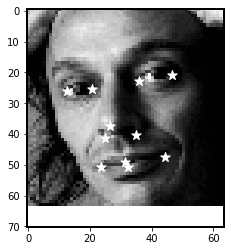

In [43]:
def show_xy(x, y_true=None, y_pred=None):
    plt.imshow(x, cmap="gray")
    if y_true is not None:
        lm = y_true.reshape((-1,3))
        plt.scatter(lm[:,0]*x.shape[1], lm[:,1]*x.shape[0], c="white", s=100, marker="*")
    if y_pred is not None:  
        lm = y_pred.reshape((-1,3))
        plt.scatter(lm[:,0]*x.shape[1], lm[:,1]*x.shape[0], c="yellow")
loader_valid.do_augmentation = False
x, y = loader_train.get_item(np.random.randint(100))
show_xy(x, y)
print(x.min(), x.max())

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Multiply, Concatenate
from functools import partial
from tensorflow.keras.backend import clear_session


def conv_block_generator(input, block_name, use_bn=True, **kwargs):
    block_num = block_name.split("_")[-1]
    kwargs["use_bias"] = False if use_bn else True
    with tf.name_scope(block_name):
        x = Conv2D(**kwargs, name=block_name + "_conv")(input)
        if use_bn:
            x = BatchNormalization(name=block_name + "_bn")(x)
        x = Activation("relu", name=block_name + "_act")(x)
    return x


def fcn3D(image_shape=(64, 64, 1), lmarks_count=68, train_mode=True) -> tf.keras.Model:
    clear_session()
    
    conv_block_inp = partial(conv_block_generator, kernel_size=(5,5), padding="same", use_bn=False)
    conv_block_reg = partial(conv_block_generator, kernel_size=(3,3), padding="same", use_bn=False)
    
    image = tf.keras.Input(shape=image_shape, dtype="float32", name="image")
    
    x = conv_block_inp(image, filters=16, block_name="conv_block_11")

    x = MaxPool2D(pool_size=(2, 2), name="pool_01")(x)
    x = conv_block_reg(x, filters=32, block_name="conv_block_21")
    x = conv_block_reg(x, filters=32, block_name="conv_block_22")

    x = MaxPool2D(pool_size=(2, 2), name="pool_02")(x)
    x = conv_block_reg(x, filters=64, block_name="conv_block_31")
    x = conv_block_reg(x, filters=64, block_name="conv_block_32")

    x = MaxPool2D(pool_size=(2, 2), name="pool_03")(x)
    x = conv_block_reg(x, filters=128, block_name="conv_block_41")
    x = Conv2D(filters=128, kernel_size=3, padding="valid", activation="relu", name="conv_block_42")(x)
    
    x = MaxPool2D(pool_size=(2, 2), name="pool_04")(x)
    x = conv_block_reg(x, filters=256, block_name="conv_block_51")
    x = Dropout(rate=0.25)(x)
    x = Conv2D(filters=lmarks_count*3, kernel_size=3, padding="valid", activation="linear", name="conv_block_52")(x)

    lmarks = x
    if train_mode:
        lmarks = Flatten()(x)
        
    model = tf.keras.Model(
        name="landmarks-fcn3D",
        inputs=image,
        outputs=lmarks
    )
    return model


model = fcn3D((imsize[1], imsize[0], 1), 12)
print(model.summary(100))

Model: "landmarks-fcn3D"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
image (InputLayer)                           [(None, 64, 64, 1)]                     0              
____________________________________________________________________________________________________
conv_block_11_conv (Conv2D)                  (None, 64, 64, 16)                      416            
____________________________________________________________________________________________________
conv_block_11_act (Activation)               (None, 64, 64, 16)                      0              
____________________________________________________________________________________________________
pool_01 (MaxPooling2D)                       (None, 32, 32, 16)                      0              
__________________________________________________________________

In [51]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Multiply, Concatenate, Lambda
from functools import partial
from tensorflow.keras.backend import clear_session


def conv_block_generator(input, block_name, use_bn=True, **kwargs):
    block_num = block_name.split("_")[-1]
    kwargs["use_bias"] = False if use_bn else True
    with tf.name_scope(block_name):
        x = Conv2D(**kwargs, name=block_name + "_conv")(input)
        if use_bn:
            x = BatchNormalization(name=block_name + "_bn")(x)
        x = Activation("relu", name=block_name + "_act")(x)
    return x


def fconv3d(image_shape=(64, 64, 1), lmarks_count=68, normalize_input=0, train_mode=True) -> tf.keras.Model:
    clear_session()
    conv_inp = partial(Conv2D, kernel_size=(5,5), use_bias=True)
    conv_reg = partial(Conv2D, kernel_size=(3,3), use_bias=True)
    
    data = tf.keras.Input(shape=image_shape, dtype="float32", name="data")
    if normalize_input == 0:
        x = data
    elif normalize_input == 1:
        x = Lambda(lambda y: y / 255)(data)
    elif normalize_input == 2:
        x = Lambda(lambda y: y - 128)(data)
        
    x = conv_inp(filters=16, padding="same", activation="relu", name="conv0")(x)

    x = MaxPool2D(pool_size=(2, 2), name="pool01")(x)
    x = conv_reg(filters=32, padding="same", activation="relu", name="conv11")(x)
    x = conv_reg(filters=32, padding="same", activation="relu", name="conv12")(x)

    x = MaxPool2D(pool_size=(2, 2), name="pool02")(x)
    x = conv_reg(filters=64, padding="same", activation="relu", name="conv21")(x)
    x = conv_reg(filters=64, padding="same", activation="relu", name="conv22")(x)

    x = MaxPool2D(pool_size=(2, 2), name="pool03")(x)
    x = conv_reg(filters=128, padding="same",  activation="relu", name="conv31")(x)
    x = conv_reg(filters=128, padding="valid", activation="relu", name="conv32")(x)
    
    x = MaxPool2D(pool_size=(2, 2), name="pool04")(x)
    x = conv_reg(filters=256, padding="same",  activation="relu", name="conv51")(x)
    x = Dropout(rate=0.25)(x)
    x = conv_reg(filters=lmarks_count*3, padding="valid",  activation="linear", name="conv52")(x)

    lmarks = x
    if train_mode:
        lmarks = Flatten()(x)
        
    model = tf.keras.Model(
        name="landmarks-fconv3d",
        inputs=data,
        outputs=lmarks
    )
    return model

logdir = "cnn3d-12"
model = fconv3d((imsize[1], imsize[0], 1), 12, normalize_input=1)
model.load_weights(os.path.join(logdir, "checkpoints/model.h5"))
print(model.summary(100))

Model: "landmarks-fconv3d"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
data (InputLayer)                            [(None, 64, 64, 1)]                     0              
____________________________________________________________________________________________________
lambda (Lambda)                              (None, 64, 64, 1)                       0              
____________________________________________________________________________________________________
conv0 (Conv2D)                               (None, 64, 64, 16)                      416            
____________________________________________________________________________________________________
pool01 (MaxPooling2D)                        (None, 32, 32, 16)                      0              
________________________________________________________________

In [61]:
model.save(os.path.join(logdir, "checkpoints", "model_final.h5"))

In [21]:
from tensorflow.keras import optimizers
logdir = create_dirs("cnn3d-12-raw")

model.compile(loss="mean_absolute_error", optimizer=optimizers.Adam(lr=0.0001))

In [22]:
gen_train = Generator(loader_train, 128)
gen_valid = Generator(loader_valid, 128)

In [23]:
history = model.fit_generator(generator=gen_train.get_iterator(train=True),
                              steps_per_epoch=20,
                              epochs=400,
                              initial_epoch=69,
                              validation_data=gen_valid.get_iterator(train=False),
                              validation_steps=25,
                              callbacks=get_callbacks(logdir, 0.001, 350),
                              use_multiprocessing=False
                              )

Epoch 70/400
20/20 [==============================] - ETA: 0s - loss: 0.0290
Epoch 00070: val_loss improved from inf to 0.02131, saving model to ./cnn3d-12-raw/checkpoints/model.h5
20/20 [==============================] - 29s 1s/step - loss: 0.0290 - val_loss: 0.0213 - lr: 0.0010
Epoch 71/400
20/20 [==============================] - ETA: 0s - loss: 0.0207
Epoch 00071: val_loss improved from 0.02131 to 0.01961, saving model to ./cnn3d-12-raw/checkpoints/model.h5
20/20 [==============================] - 30s 2s/step - loss: 0.0207 - val_loss: 0.0196 - lr: 0.0010
Epoch 72/400
20/20 [==============================] - ETA: 0s - loss: 0.0193
Epoch 00072: val_loss improved from 0.01961 to 0.01841, saving model to ./cnn3d-12-raw/checkpoints/model.h5
20/20 [==============================] - 31s 2s/step - loss: 0.0193 - val_loss: 0.0184 - lr: 0.0010
Epoch 73/400
20/20 [==============================] - ETA: 0s - loss: 0.0191
Epoch 00073: val_loss improved from 0.01841 to 0.01823, saving model to 

Epoch 103/400
20/20 [==============================] - ETA: 0s - loss: 0.0162
Epoch 00103: val_loss improved from 0.01542 to 0.01535, saving model to ./cnn3d-12-raw/checkpoints/model.h5
20/20 [==============================] - 31s 2s/step - loss: 0.0162 - val_loss: 0.0154 - lr: 0.0010
Epoch 104/400
20/20 [==============================] - ETA: 0s - loss: 0.0159
Epoch 00104: val_loss improved from 0.01535 to 0.01520, saving model to ./cnn3d-12-raw/checkpoints/model.h5
20/20 [==============================] - 30s 2s/step - loss: 0.0159 - val_loss: 0.0152 - lr: 0.0010
Epoch 105/400
20/20 [==============================] - ETA: 0s - loss: 0.0161
Epoch 00105: val_loss did not improve from 0.01520
20/20 [==============================] - 30s 1s/step - loss: 0.0161 - val_loss: 0.0165 - lr: 0.0010
Epoch 106/400
20/20 [==============================] - ETA: 0s - loss: 0.0158
Epoch 00106: val_loss improved from 0.01520 to 0.01517, saving model to ./cnn3d-12-raw/checkpoints/model.h5
20/20 [======

Epoch 137/400
20/20 [==============================] - ETA: 0s - loss: 0.0147
Epoch 00137: val_loss did not improve from 0.01391
20/20 [==============================] - 30s 1s/step - loss: 0.0147 - val_loss: 0.0147 - lr: 0.0010
Epoch 138/400
20/20 [==============================] - ETA: 0s - loss: 0.0145
Epoch 00138: val_loss did not improve from 0.01391
20/20 [==============================] - 30s 2s/step - loss: 0.0145 - val_loss: 0.0140 - lr: 0.0010
Epoch 139/400
20/20 [==============================] - ETA: 0s - loss: 0.0147
Epoch 00139: val_loss did not improve from 0.01391
20/20 [==============================] - 30s 2s/step - loss: 0.0147 - val_loss: 0.0145 - lr: 0.0010
Epoch 140/400
20/20 [==============================] - ETA: 0s - loss: 0.0143
Epoch 00140: val_loss did not improve from 0.01391
20/20 [==============================] - 29s 1s/step - loss: 0.0143 - val_loss: 0.0145 - lr: 0.0010
Epoch 141/400
20/20 [==============================] - ETA: 0s - loss: 0.0141
Epoch 

Epoch 172/400
20/20 [==============================] - ETA: 0s - loss: 0.0136
Epoch 00172: val_loss did not improve from 0.01317
20/20 [==============================] - 29s 1s/step - loss: 0.0136 - val_loss: 0.0137 - lr: 0.0010
Epoch 173/400
20/20 [==============================] - ETA: 0s - loss: 0.0135
Epoch 00173: val_loss did not improve from 0.01317
20/20 [==============================] - 30s 1s/step - loss: 0.0135 - val_loss: 0.0140 - lr: 0.0010
Epoch 174/400
20/20 [==============================] - ETA: 0s - loss: 0.0134
Epoch 00174: val_loss did not improve from 0.01317
20/20 [==============================] - 30s 1s/step - loss: 0.0134 - val_loss: 0.0145 - lr: 0.0010
Epoch 175/400
20/20 [==============================] - ETA: 0s - loss: 0.0136
Epoch 00175: val_loss did not improve from 0.01317
20/20 [==============================] - 31s 2s/step - loss: 0.0136 - val_loss: 0.0138 - lr: 0.0010
Epoch 176/400
20/20 [==============================] - ETA: 0s - loss: 0.0134
Epoch 

Epoch 207/400
20/20 [==============================] - ETA: 0s - loss: 0.0132
Epoch 00207: val_loss did not improve from 0.01248
20/20 [==============================] - 29s 1s/step - loss: 0.0132 - val_loss: 0.0129 - lr: 0.0010
Epoch 208/400
20/20 [==============================] - ETA: 0s - loss: 0.0131
Epoch 00208: val_loss did not improve from 0.01248
20/20 [==============================] - 29s 1s/step - loss: 0.0131 - val_loss: 0.0130 - lr: 0.0010
Epoch 209/400
20/20 [==============================] - ETA: 0s - loss: 0.0126
Epoch 00209: val_loss did not improve from 0.01248
20/20 [==============================] - 30s 2s/step - loss: 0.0126 - val_loss: 0.0132 - lr: 0.0010
Epoch 210/400
20/20 [==============================] - ETA: 0s - loss: 0.0130
Epoch 00210: val_loss did not improve from 0.01248
20/20 [==============================] - 31s 2s/step - loss: 0.0130 - val_loss: 0.0129 - lr: 0.0010
Epoch 211/400
20/20 [==============================] - ETA: 0s - loss: 0.0128
Epoch 

Epoch 243/400
20/20 [==============================] - ETA: 0s - loss: 0.0129
Epoch 00243: val_loss did not improve from 0.01243
20/20 [==============================] - 31s 2s/step - loss: 0.0129 - val_loss: 0.0128 - lr: 0.0010
Epoch 244/400
20/20 [==============================] - ETA: 0s - loss: 0.0126
Epoch 00244: val_loss did not improve from 0.01243
20/20 [==============================] - 30s 2s/step - loss: 0.0126 - val_loss: 0.0130 - lr: 0.0010
Epoch 245/400
20/20 [==============================] - ETA: 0s - loss: 0.0125
Epoch 00245: val_loss did not improve from 0.01243
20/20 [==============================] - 30s 1s/step - loss: 0.0125 - val_loss: 0.0131 - lr: 0.0010
Epoch 246/400
20/20 [==============================] - ETA: 0s - loss: 0.0127
Epoch 00246: val_loss did not improve from 0.01243
20/20 [==============================] - 31s 2s/step - loss: 0.0127 - val_loss: 0.0134 - lr: 0.0010
Epoch 247/400
20/20 [==============================] - ETA: 0s - loss: 0.0123
Epoch 

20/20 [==============================] - ETA: 0s - loss: 0.0121
Epoch 00278: val_loss did not improve from 0.01203
20/20 [==============================] - 30s 2s/step - loss: 0.0121 - val_loss: 0.0125 - lr: 0.0010
Epoch 279/400
20/20 [==============================] - ETA: 0s - loss: 0.0120
Epoch 00279: val_loss did not improve from 0.01203
20/20 [==============================] - 30s 2s/step - loss: 0.0120 - val_loss: 0.0129 - lr: 0.0010
Epoch 280/400
20/20 [==============================] - ETA: 0s - loss: 0.0123
Epoch 00280: val_loss did not improve from 0.01203
20/20 [==============================] - 32s 2s/step - loss: 0.0123 - val_loss: 0.0125 - lr: 0.0010
Epoch 281/400
20/20 [==============================] - ETA: 0s - loss: 0.0120
Epoch 00281: val_loss did not improve from 0.01203
20/20 [==============================] - 30s 2s/step - loss: 0.0120 - val_loss: 0.0122 - lr: 0.0010
Epoch 282/400
20/20 [==============================] - ETA: 0s - loss: 0.0123
Epoch 00282: val_los

Epoch 314/400
20/20 [==============================] - ETA: 0s - loss: 0.0121
Epoch 00314: val_loss did not improve from 0.01201
20/20 [==============================] - 31s 2s/step - loss: 0.0121 - val_loss: 0.0123 - lr: 0.0010
Epoch 315/400
20/20 [==============================] - ETA: 0s - loss: 0.0119
Epoch 00315: val_loss did not improve from 0.01201
20/20 [==============================] - 30s 2s/step - loss: 0.0119 - val_loss: 0.0126 - lr: 0.0010
Epoch 316/400
20/20 [==============================] - ETA: 0s - loss: 0.0117
Epoch 00316: val_loss improved from 0.01201 to 0.01195, saving model to ./cnn3d-12-raw/checkpoints/model.h5
20/20 [==============================] - 29s 1s/step - loss: 0.0117 - val_loss: 0.0120 - lr: 0.0010
Epoch 317/400
20/20 [==============================] - ETA: 0s - loss: 0.0118
Epoch 00317: val_loss did not improve from 0.01195
20/20 [==============================] - 29s 1s/step - loss: 0.0118 - val_loss: 0.0133 - lr: 0.0010
Epoch 318/400
20/20 [======

20/20 [==============================] - ETA: 0s - loss: 0.0119
Epoch 00349: val_loss did not improve from 0.01164
20/20 [==============================] - 30s 2s/step - loss: 0.0119 - val_loss: 0.0126 - lr: 0.0010
Epoch 350/400
20/20 [==============================] - ETA: 0s - loss: 0.0116
Epoch 00350: val_loss improved from 0.01164 to 0.01149, saving model to ./cnn3d-12-raw/checkpoints/model.h5
20/20 [==============================] - 31s 2s/step - loss: 0.0116 - val_loss: 0.0115 - lr: 0.0010
Epoch 351/400
20/20 [==============================] - ETA: 0s - loss: 0.0112
Epoch 00351: val_loss did not improve from 0.01149
20/20 [==============================] - 29s 1s/step - loss: 0.0112 - val_loss: 0.0116 - lr: 1.0000e-04
Epoch 352/400
20/20 [==============================] - ETA: 0s - loss: 0.0109
Epoch 00352: val_loss improved from 0.01149 to 0.01142, saving model to ./cnn3d-12-raw/checkpoints/model.h5
20/20 [==============================] - 30s 2s/step - loss: 0.0109 - val_loss: 

20/20 [==============================] - ETA: 0s - loss: 0.0103
Epoch 00382: val_loss did not improve from 0.01104
20/20 [==============================] - 30s 2s/step - loss: 0.0103 - val_loss: 0.0111 - lr: 1.0000e-04
Epoch 383/400
20/20 [==============================] - ETA: 0s - loss: 0.0103
Epoch 00383: val_loss improved from 0.01104 to 0.01102, saving model to ./cnn3d-12-raw/checkpoints/model.h5
20/20 [==============================] - 30s 2s/step - loss: 0.0103 - val_loss: 0.0110 - lr: 1.0000e-04
Epoch 384/400
20/20 [==============================] - ETA: 0s - loss: 0.0102
Epoch 00384: val_loss did not improve from 0.01102
20/20 [==============================] - 31s 2s/step - loss: 0.0102 - val_loss: 0.0111 - lr: 1.0000e-04
Epoch 385/400
20/20 [==============================] - ETA: 0s - loss: 0.0103
Epoch 00385: val_loss did not improve from 0.01102
20/20 [==============================] - 31s 2s/step - loss: 0.0103 - val_loss: 0.0111 - lr: 1.0000e-04
Epoch 386/400
20/20 [====

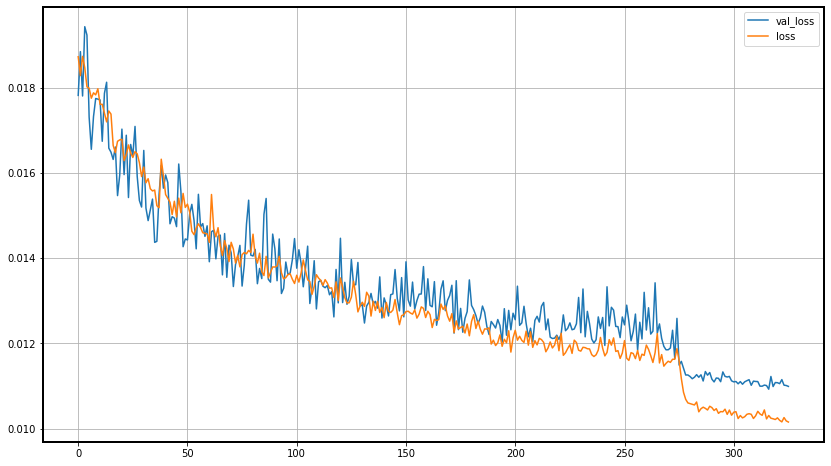

In [24]:
model.save(os.path.join(logdir, "checkpoints", "model_final.h5"))
plot_history(logdir, history)

## Model Validation

In [44]:
# CALC TEST METRICS WITHOUT AUGMENTATION
gen_test = Generator(loader_valid, 7)
model.evaluate(gen_test.get_iterator(train=False), steps=100)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [26]:
# CALC TEST METRICS WITH AUGMENTATION
loader_test = Loader300W(os.path.join(data_dir, "test_crop"), imsize, valid_size=0)
gen_test = Generator(loader_test, 10)
model.evaluate(gen_test.get_iterator(train=True), steps=100)

NameError: name 'Loader300W' is not defined

In [32]:
def show_xy(x, y_true=None, y_pred=None):
    plt.imshow(x, cmap="gray")
    if y_true is not None:
        plt.scatter(y_true[:,0]*x.shape[1], y_true[:,1]*x.shape[0], c="white", s=100, marker="*")
    if y_pred is not None:  
        plt.scatter(y_pred[:,0]*x.shape[1], y_pred[:,1]*x.shape[0], c="yellow")

[0.00709526 0.00925562 0.03556078]


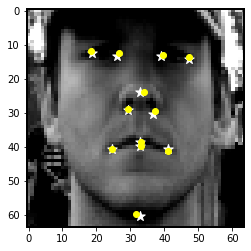

In [53]:
loader_valid.do_augmentation = True
item_id = np.random.randint(100)
x, y = loader_valid.get_item(loader_valid.valid_set[item_id])

lmarks = model.predict(np.expand_dims(x, 0)).flatten()
#print(model.evaluate(np.expand_dims(x, 0), np.expand_dims(y, 0), steps=1, verbose=0))
show_xy(x, y.reshape(-1, 3), lmarks.reshape(-1, 3))
print(abs(lmarks.reshape(-1, 3) - y.reshape(-1, 3)).mean(0))

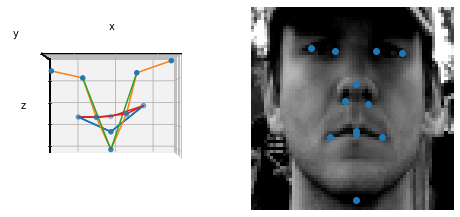

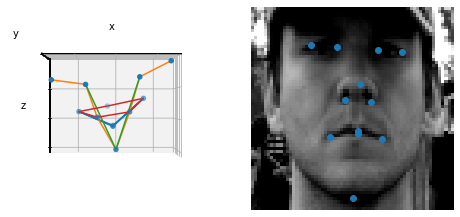

In [60]:
import matplotlib.pyplot as plt
from shutil import rmtree
#from imageio import get_writer

def plot3D(frame, lmarks):
    lmarks = lmarks.copy().reshape((-1,3))
    lmarks[:, 0] = lmarks[:, 0]*x.shape[1]
    lmarks[:, 1] = lmarks[:, 1]*x.shape[0]
    lmarks[:, 2] = lmarks[:, 2]*(x.shape[0]+x.shape[1])*2
    lmarks3d = lmarks.copy()
    lmarks3d[:, 0] = x.shape[1]-lmarks3d[:, 0]

    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.get_zaxis().set_ticklabels([])

    xc, yc, zc = lmarks3d[:, 0], lmarks3d[:, 1], lmarks3d[:, 2]
    conts = [[11, 8, 10, 9, 11],
             [4, 5, 2, 1, 3, 6, 7],
             [5, 1, 6],
             [8, 2, 3, 9, 0, 8]]
    for cont in conts:
        ax.plot(xc[cont], yc[cont], zs=zc[cont])
    
    ax.scatter(lmarks3d[:, 0], lmarks3d[:, 1], lmarks3d[:, 2])
    #ax.azim = 45
    #ax.dist = 8
    #ax.elev = 20
    ax.view_init(180, 90)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(frame, cmap="gray")
    plt.scatter(lmarks[:, 0], lmarks[:, 1])
    plt.axis("off")

plot3D(x, y)
plot3D(x, lmarks)

In [24]:
from testutils import CropTester
def keras_wrapper(img_crop):
    """
    input img_crop: face crop before resize
    output: landmarks as flatten np.array
    """
    net_input = cv2.resize(img_crop, model.input_shape[1:-1][::-1])
    net_input = (net_input.astype(np.float32)/255)
    net_input = net_input.reshape(1, net_input.shape[0], net_input.shape[1], 1)
    lmarks = model.predict(net_input)
    return lmarks

ct = CropTester(keras_wrapper, num_iterations=10)
ct.test_image("/media/hdd/public/Datasets/faces/300W/test_crop/helen/000009.png")
ct.mean_pixel_std()

>>> Output images are placed in ./croptest_out folder


1.8744101612484776

In [10]:
model = fcn3D((imsize[1], imsize[0], 1), 12, train_mode=False)
model.load_weights("cnn3d-12/checkpoints/model_final.h5", by_name=True, skip_mismatch=False)
model.save("cnn3d-12/checkpoints/model_infer.h5")

In [11]:
!/usr/bin/python3.7 freeze_graph.py cnn3d-12/checkpoints/model_infer.h5

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2022-04-07 11:57:57.062850: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-04-07 11:57:57.082176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: Tesla M40 computeCapability: 5.2
coreClock: 1.112GHz coreCount: 24 deviceMemorySize: 11.18GiB deviceMemoryBandwidth: 268.58GiB/s
2022-04-07 11:57:57.082522: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-04-07 11:57:57.084570: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-04-07 11:57:57.086475: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-04-07 11:57:57.086936: I tensorflow/stream_executor/platform/def